In [1]:
import pandas as pd

In [3]:
stocks_data=pd.read_csv("C:\\Users\\Lenovo\\Downloads\\stocks\\stocks.csv")

In [4]:
stocks_data.head(5)

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


Ticker: The stock symbol.
Date: The date of the trading session.
Open: The opening price of the stock for the trading session.
High: The highest price of the stock during the trading session.
Low: The lowest price of the stock during the trading session.
Close: The closing price of the stock for the trading session.
Adj Close: The adjusted closing price of the stock (adjusted for things like dividends and stock splits).
Volume: The number of shares traded during the trading session.

Convert the Date column to a datetime type for time series analysis.

In [5]:
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])

In [6]:
missing_values = stocks_data.isnull().sum()
unique_stocks = stocks_data['Ticker'].value_counts()
print(missing_values)

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
print(unique_stocks)

Ticker
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: count, dtype: int64


In [8]:
time_range = stocks_data['Date'].min(), stocks_data['Date'].max()
print(time_range)

(Timestamp('2023-02-07 00:00:00'), Timestamp('2023-05-05 00:00:00'))


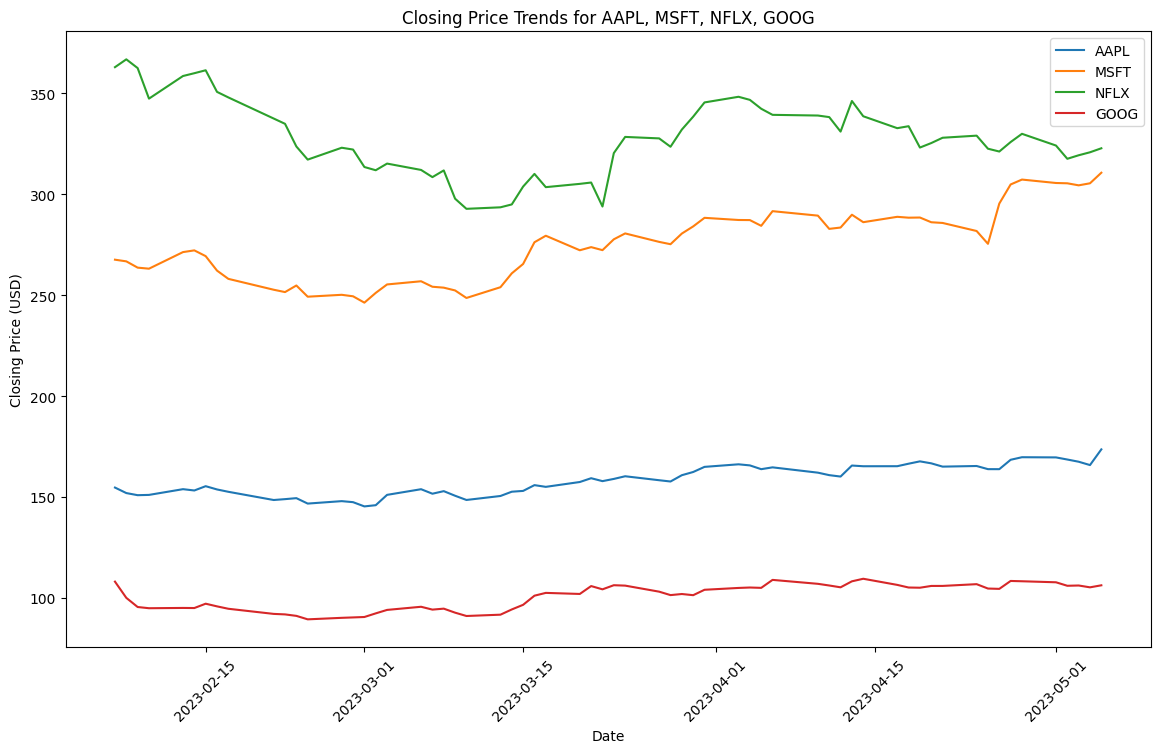

In [11]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(14,8))
for ticker in unique_stocks.index:
    subset = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(subset['Date'], subset['Close'], label=ticker)
ax.set_title('Closing Price Trends for AAPL, MSFT, NFLX, GOOG')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()
plt.xticks(rotation=45)
plt.show()


Closing price trends for Apple, Netflix, Microsoft, Google

Given the multivariate nature of our data, a Vector AutoRegression (VAR) model could be a suitable choice. VAR models can capture the linear interdependencies among multiple time series, which makes them a good fit for forecasting the prices of several stocks simultaneously.

Use the Augmented Dickey-Fuller (ADF) test for each stock’s closing price.
Depending on the ADF test results, we may need to transform the data (e.g., by differencing) to achieve stationarity.
Train the VAR model and forecast the future values.

In [13]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title=''):
    print(f'ADF Test on "{title}"')
    result = adfuller(series, autolag='AIC')  # ADF test
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string()) 
    print('\n')


In [14]:
for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Close']
    adf_test(series, title=ticker)

ADF Test on "AAPL"
ADF Test Statistic             -0.291693
p-value                         0.926673
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "MSFT"
ADF Test Statistic             -0.149807
p-value                         0.944246
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "NFLX"
ADF Test Statistic             -2.150926
p-value                         0.224536
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "GOOG"
ADF Test Statistic             -1.431504
p-value         

AAPL: The p-value is 0.927, suggesting we failed to reject the null hypothesis, and the series is non-stationary.
MSFT: With a p-value of 0.944, this series is also non-stationary.
NFLX: The p-value is 0.225, indicating non-stationarity.
GOOG: The p-value is 0.567, again indicating non-stationarity

We will make the data stationary 

In [15]:
# differencing the 'Close' price of each stock to make the series stationary
stocks_data['Diff_Close'] = stocks_data.groupby('Ticker')['Close'].transform(lambda x: x.diff())


In [16]:
for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Diff_Close'].dropna()
    adf_test(series, title=f"{ticker} - Differenced")

ADF Test on "AAPL - Differenced"
ADF Test Statistic             -5.238104
p-value                         0.000007
#Lags Used                      4.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137


ADF Test on "MSFT - Differenced"
ADF Test Statistic            -5.895024e+00
p-value                        2.864876e-07
#Lags Used                     1.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00


ADF Test on "NFLX - Differenced"
ADF Test Statistic            -8.022480e+00
p-value                        2.058613e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.59319

low p-value suggest the data is now stationary

In [17]:
from statsmodels.tsa.vector_ar.var_model import VAR
#training VAR model
# prepare the dataset 
var_data = stocks_data.pivot(index='Date', columns='Ticker', values='Diff_Close').dropna()

model = VAR(var_data)
model_fitted = model.fit(ic='aic')
forecast_steps = 5
forecasted_values = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=forecast_steps)
forecasted_df = pd.DataFrame(forecasted_values, index=pd.date_range(start=var_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=var_data.columns)

for column in forecasted_df.columns:
    forecasted_df[column] = (stocks_data.groupby('Ticker')['Close'].last()[column] + forecasted_df[column].cumsum())

print(forecasted_df)

Ticker            AAPL        GOOG        MSFT        NFLX
2023-05-06  174.369001  113.624024  320.179608  327.604320
2023-05-07  169.684437  104.915080  318.416783  342.704109
2023-05-08  168.190894  107.828473  329.210732  367.542312
2023-05-09  160.836027   99.287041  326.849012  348.088074
2023-05-10  167.645928  101.392914  317.986680  387.059442


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


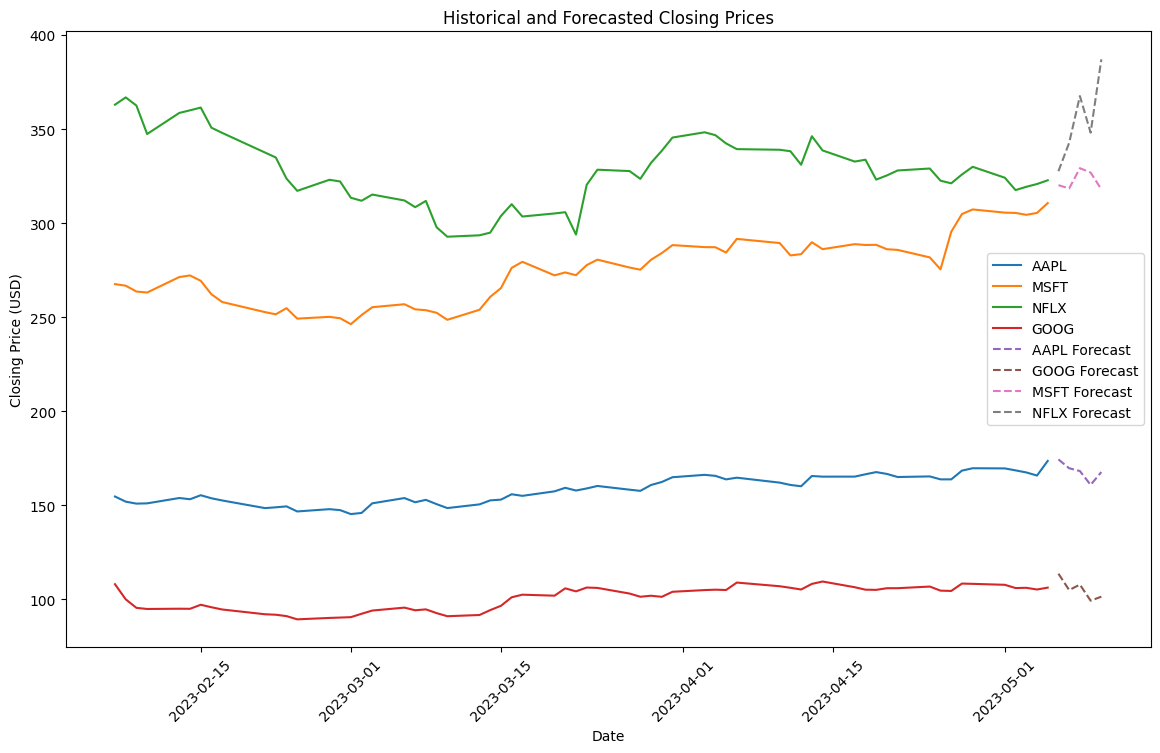

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))

# plot historical closing prices for each stock
for ticker in unique_stocks.index:
    historical_data = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(historical_data['Date'], historical_data['Close'], label=ticker)

# plot the forecasted closing prices
for column in forecasted_df.columns:
    ax.plot(forecasted_df.index, forecasted_df[column], label=f'{column} Forecast', linestyle='--')

ax.set_title('Historical and Forecasted Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show()